# Analysis completed by Stephen Stark
# Jumpman23 - Exploratory Data Analysis

Jumpman23 is an on-demand delivery platform connecting “Jumpmen” and customers  purchasing a variety of goods. Jumpman23 will send Jumpmen to merchants to purchase and  pickup any items requested by the customer. Whenever possible, Jumpman23 will order the  requested items ahead to save the Jumpmen time. Each time a Jumpman23 delivery is  completed, a record is saved to the Jumpman23 database that contains information about that  delivery. Jumpman23 is growing fast and has just launched in its newest market -- New York City.

# Objective
The objective of this notebook is to answer the questions:
- How are things going in New York?
- Are there data integrity issues? 
    - If so, where are they and how do they impact the analysis?


I will use the dataset provided by Postmates.

# Summary
1. [Understand the data](#understand)\
    1.1 [N/A's?](#na)\
2. 
3.
4. 
5.
6. [Scratch](#scratch)

### Understanding the Delivery Process

A customer orders something from a business such as a restaurant or grocery store. Jumpman23 connects that customer with a Jumpman who will then travel to go pickup the item. The Jumpman picks up the item to bring back to the customer. The Jumpman travels by foot, bike, car, scooter, or other method to deliver the item to the customer. Once the item is delivered, a record is created with the following journey attribute information. 

### Understanding Delivery Attributes

- **Job_ID:**  a unique identifier of a delivery
- **Customer_id:** a unique identifier for the Jumpman23 customer
- **Jumpman_id:**  a unique identifier for the Jumpman who completed the delivery
- **vehicle_type:** The method of transport the Jumpman used to complete the delivery
- **pickup_place:** The name of the Pickup location
- **place_category:** A categorization of the Pickup location
- **Item_name:** the name of the item requested
- **Item_quantity:** how many of that item was requested
- **Item_category_name:** categorization provided by the merchant, think “appetizers”, “soups” etc
- **How_long_it_took_to_order:** how long it took to place the order [interval]
- **pickup_lat:** the coordinates of the pickup location
- **pickup_lon:** the coordinates of the pickup location
- **dropoff_lat:** the coordinations of the dropoff location
- **dropoff_lon:** the coordinations of the dropoff location
- **when_the_delivery_started:** localized timestamp representing when the delivery began
- **when_the_Jumpman_arrived_at_pickup:** localized timestamp representing when the Jumpman arrived at the pickup location
- **when_the_Jumpman_left_pickup:** localized timestamp representing when the Jumpman left the pickup location
- **when_the_Jumpman_arrived_at_dropoff :** localized timestamp representing when the Jumpman reached the customer

## Import Neccesary Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from collections import Counter
import haversine as hs
import os as os
from datetime import datetime, timedelta
import re
%matplotlib inline

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.listdir()

['.DS_Store',
 'README.md',
 'img',
 '.ipynb_checkpoints',
 'Stephen_Stark_Jumpman23Analysis.ipynb',
 '.git']

In [4]:
df = pd.read_csv('../Jumpman23/analyze_me.csv')

<a id='understand'></a>
## Understand the data

In order to answer the question of 'how are things going in NYC', we need to first spot check the data. We know there are potential data integrity issues. Lets look column by column to determine what sort of analysis we can do.

In [5]:
print(df.shape)
print(df.info())

(5983, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
delivery_id                            5983 non-null int64
customer_id                            5983 non-null int64
jumpman_id                             5983 non-null int64
vehicle_type                           5983 non-null object
pickup_place                           5983 non-null object
place_category                         5100 non-null object
item_name                              4753 non-null object
item_quantity                          4753 non-null float64
item_category_name                     4753 non-null object
how_long_it_took_to_order              3038 non-null object
pickup_lat                             5983 non-null float64
pickup_lon                             5983 non-null float64
dropoff_lat                            5983 non-null float64
dropoff_lon                            5983 non-null float64
when_the_delivery_started              5

In [6]:
#Count of N/A or Null values in each column
df.isna().sum()

delivery_id                               0
customer_id                               0
jumpman_id                                0
vehicle_type                              0
pickup_place                              0
place_category                          883
item_name                              1230
item_quantity                          1230
item_category_name                     1230
how_long_it_took_to_order              2945
pickup_lat                                0
pickup_lon                                0
dropoff_lat                               0
dropoff_lon                               0
when_the_delivery_started                 0
when_the_Jumpman_arrived_at_pickup      550
when_the_Jumpman_left_pickup            550
when_the_Jumpman_arrived_at_dropoff       0
dtype: int64

### 'delivery_id','customer_id','jumpman_id'

In [7]:
print('Count of records:', len(df))
print('---')
print('Count of unique elements in each id column:')

id_cols = ['delivery_id','customer_id','jumpman_id']
for i in id_cols:
    print(i,':', df[i].nunique())

Count of records: 5983
---
Count of unique elements in each id column:
delivery_id : 5214
customer_id : 3192
jumpman_id : 578


It is important to note the total number of records 5983 is greater than the unique elements for each id. I would expect customer_id and jumpman_id to be used mutliple times. However, I want to look into why the same delivery_id has been used multiple times.

In [8]:
df[df['delivery_id'].duplicated()].head(3)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
82,1314550,348787,119813,bicycle,Otto Enoteca Pizzeria,Italian,Prosciutto Arugula,1.0,Pizzas,00:22:42.942105,40.732064,-73.996155,40.767582,-73.983704,2014-10-07 18:40:38.769589,2014-10-07 18:49:49.978276,2014-10-07 19:27:58.470009,2014-10-07 19:55:56.804909
207,1332526,48677,152676,bicycle,Shake Shack,Burger,Smoke Shack,1.0,Burgers,NaN,40.715279,-74.014860,40.724520,-73.993420,2014-10-10 18:41:05.90546,2014-10-10 19:04:31.649579,2014-10-10 19:46:22.211936,2014-10-10 20:15:31.476676
244,1319971,94027,119255,walker,Trader Joe's,Grocery Store,Organic Autumn Wheat,1.0,Breakfast & Cereal,NaN,40.741740,-73.993650,40.736971,-73.985844,2014-10-08 19:33:52.549234,2014-10-08 19:45:18.293971,2014-10-08 20:38:07.37508,2014-10-08 20:49:29.420191


Based on the query below, it looks like multiple items from the same order are broken out on different records. I would expect all the other attributes to be the same for all cases. One way I could handle this is to merge the items into a list for each record. For the purposes of this analysis, I'll drop the duplicate records as I don't see a meaningful reason for including them in the analysis.

In [9]:
#sample duplicate row
df[df['delivery_id']==1272701]

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
1008,1272701,81085,112646,bicycle,Mighty Quinn's BBQ,BBQ,Brisket,1.0,Meats,NaN,40.727519,-73.988671,40.723962,-73.993393,2014-10-01 12:12:24.393054,2014-10-01 12:17:22.929789,2014-10-01 12:27:42.369732,2014-10-01 12:34:27.142996
5080,1272701,81085,112646,bicycle,Mighty Quinn's BBQ,BBQ,Housemade Iced Tea,1.0,Beverages,NaN,40.727519,-73.988671,40.723962,-73.993393,2014-10-01 12:12:24.393054,2014-10-01 12:17:22.929789,2014-10-01 12:27:42.369732,2014-10-01 12:34:27.142996


In [10]:
#duplicate row dataset
df[df['delivery_id'].duplicated()].sort_values(by='delivery_id')

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
5080,1272701,81085,112646,bicycle,Mighty Quinn's BBQ,BBQ,Housemade Iced Tea,1.0,Beverages,NaN,40.727519,-73.988671,40.723962,-73.993393,2014-10-01 12:12:24.393054,2014-10-01 12:17:22.929789,2014-10-01 12:27:42.369732,2014-10-01 12:34:27.142996
2299,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Moroccan Cigars (5 pc),1.0,Appetizers,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
2986,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Watermelon,1.0,Desserts,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
5386,1274328,255435,23359,bicycle,Lure Fishbar,Seafood,King Salmon,3.0,Sushi & Sashimi,00:11:23.081868,40.724635,-73.998402,40.743568,-73.972405,2014-10-01 17:47:16.707187,2014-10-01 17:44:49.255589,2014-10-01 18:21:08.892224,2014-10-01 18:41:16.203243
4578,1274372,82041,133293,bicycle,Parm,Italian,Chicken Parm,1.0,Sandwiches,00:02:31.470754,40.723020,-73.995854,40.720479,-74.001549,2014-10-01 17:57:34.871703,2014-10-01 17:57:34.041223,2014-10-01 18:09:53.957556,2014-10-01 18:20:05.578047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,1490188,166368,174143,motorcycle,Prosperity Dumpling,Chinese,Chives and Pork Dumplings in Soup,1.0,Dumplings,NaN,40.716001,-73.993210,40.775973,-73.947845,2014-10-30 21:00:30.703848,2014-10-30 21:08:00.931773,2014-10-30 21:44:21.145721,2014-10-30 22:07:09.83358
4119,1490188,166368,174143,motorcycle,Prosperity Dumpling,Chinese,Vegetable and Pork Dumplings in Soup,1.0,Dumplings,NaN,40.716001,-73.993210,40.775973,-73.947845,2014-10-30 21:00:30.703848,2014-10-30 21:08:00.931773,2014-10-30 21:44:21.145721,2014-10-30 22:07:09.83358
4983,1490744,52256,38597,bicycle,Han Dynasty,Chinese,Dan Dan Noodle,1.0,Noodles,00:09:51.159698,40.732213,-73.988072,40.732288,-73.987752,2014-10-30 21:44:05.205404,2014-10-30 21:51:58.394867,2014-10-30 22:06:52.148926,2014-10-30 22:08:06.563304
4074,1490744,52256,38597,bicycle,Han Dynasty,Chinese,Bok Choy with Black Mushrooms,1.0,Vegetables,00:09:51.159698,40.732213,-73.988072,40.732288,-73.987752,2014-10-30 21:44:05.205404,2014-10-30 21:51:58.394867,2014-10-30 22:06:52.148926,2014-10-30 22:08:06.563304


In [11]:
#drop duplicate rows based on delivery_id column
df = df.drop_duplicates(subset=['delivery_id'])

### 'vehicle_type','pickup_place','place_category','item_name','item_category_name'

The integrity of the following columns can be assessed by simply looking at the counts of the unique values in each set, as well as the size of the set itself.

In [12]:
select_cols = ['vehicle_type',
               'pickup_place',
               'place_category',
               'item_name',
               'item_category_name']

for col in select_cols:
    print(pd.DataFrame(df[col].value_counts()))

            vehicle_type
bicycle             3740
car                 1050
walker               234
van                   69
scooter               64
truck                 38
motorcycle            19
                           pickup_place
Shake Shack                         266
Momofuku Milk Bar                   162
The Meatball Shop                   153
sweetgreen                          138
Blue Ribbon Fried Chicken           115
...                                 ...
Hunan Manor                           1
Community Food & Juice                1
Ghenet Brooklyn                       1
Royale                                1
Think Coffee                          1

[898 rows x 1 columns]
                       place_category
Italian                           437
Burger                            395
American                          357
Japanese                          335
Dessert                           277
Chinese                           265
Sushi                         

### 'item_quantity', 'how_long_it_took_to_order'
The integrity of the following columns can be assessed by looking at several measures of the statistical distribution of each set.

In [13]:
df['item_quantity'].describe()

count    3984.000000
mean        1.245231
std         0.781632
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        16.000000
Name: item_quantity, dtype: float64

In [14]:
df['how_long_it_took_to_order'].describe()

count                2579
unique               2579
top       00:06:40.312795
freq                    1
Name: how_long_it_took_to_order, dtype: object

### Pickup & Dropoff Locations
Assessment of pickup and dropoff locations

In [15]:
import ipyplot

images_list = ['img/Pickup.png','img/Dropoff.png',
               'img/Pickup_zoom.png','img/Dropoff_zoom.png']

ipyplot.plot_images(images_list, img_width=500)

The pickup and dropoff locations all appear to be valid.

### 'when_the_delivery_started','when_the_Jumpman_arrived_at_pickup','when_the_Jumpman_left_pickup','when_the_Jumpman_arrived_at_dropoff'
Check the min and max values for the relevant timestamp columns. It the data is for the month of October.

In [16]:
date_cols = ['when_the_delivery_started',
             'when_the_Jumpman_arrived_at_pickup',
             'when_the_Jumpman_left_pickup',
             'when_the_Jumpman_arrived_at_dropoff']

time_cols = ['how_long_it_took_to_order']
for i in date_cols:
    df[i] = pd.to_datetime(df[i])
    
for i in time_cols:
    df[i] = pd.to_timedelta(df[i])

for col in date_cols:
    print(col+":",
          df[col].min(),
          ",",
          df[col].max())
    
for col in time_cols:
    print(col+":",
          df[col].min(),
          ",",
          df[col].max())



when_the_delivery_started: 2014-10-01 00:07:58.632482 , 2014-10-30 23:08:43.481900
when_the_Jumpman_arrived_at_pickup: 2014-10-01 00:39:31.086322 , 2014-10-30 23:10:31.062088
when_the_Jumpman_left_pickup: 2014-10-01 00:59:57.522402 , 2014-10-30 23:23:51.143279
when_the_Jumpman_arrived_at_dropoff: 2014-10-01 00:30:21.109149 , 2014-10-30 23:29:44.866438
how_long_it_took_to_order: 0 days 00:01:22.997519 , 0 days 01:13:13.266118


## Missing Data

Now that we've gone through all of the columns, we'll need to come up with a strategy for how to handle the remaining missing information.

In [17]:
df.isnull().sum()

delivery_id                               0
customer_id                               0
jumpman_id                                0
vehicle_type                              0
pickup_place                              0
place_category                          841
item_name                              1230
item_quantity                          1230
item_category_name                     1230
how_long_it_took_to_order              2635
pickup_lat                                0
pickup_lon                                0
dropoff_lat                               0
dropoff_lon                               0
when_the_delivery_started                 0
when_the_Jumpman_arrived_at_pickup      495
when_the_Jumpman_left_pickup            495
when_the_Jumpman_arrived_at_dropoff       0
dtype: int64

In [18]:
df['place_category'].fillna('Not Disclosed', inplace=True)
df['item_name'].fillna('Not Disclosed', inplace=True)
df['item_quantity'].fillna('Not Disclosed', inplace=True)
df['item_category_name'].fillna('Not Disclosed', inplace=True)
df['how_long_it_took_to_order'].fillna('Not Disclosed', inplace=True)


In [19]:
df.isnull().sum()/len(df)


delivery_id                            0.000000
customer_id                            0.000000
jumpman_id                             0.000000
vehicle_type                           0.000000
pickup_place                           0.000000
place_category                         0.000000
item_name                              0.000000
item_quantity                          0.000000
item_category_name                     0.000000
how_long_it_took_to_order              0.000000
pickup_lat                             0.000000
pickup_lon                             0.000000
dropoff_lat                            0.000000
dropoff_lon                            0.000000
when_the_delivery_started              0.000000
when_the_Jumpman_arrived_at_pickup     0.094937
when_the_Jumpman_left_pickup           0.094937
when_the_Jumpman_arrived_at_dropoff    0.000000
dtype: float64

In [20]:
#Less than 10% of the Jumpman Arrived at Pickup & left Pickup are empty, therefore, I'm comfortable dropping the entries with missing data
df = df.dropna(subset=['when_the_Jumpman_arrived_at_pickup','when_the_Jumpman_left_pickup'])

In [21]:
df.isnull().sum()

delivery_id                            0
customer_id                            0
jumpman_id                             0
vehicle_type                           0
pickup_place                           0
place_category                         0
item_name                              0
item_quantity                          0
item_category_name                     0
how_long_it_took_to_order              0
pickup_lat                             0
pickup_lon                             0
dropoff_lat                            0
dropoff_lon                            0
when_the_delivery_started              0
when_the_Jumpman_arrived_at_pickup     0
when_the_Jumpman_left_pickup           0
when_the_Jumpman_arrived_at_dropoff    0
dtype: int64

In [22]:
df['place_category'].unique()

array(['Pizza', 'Burger', 'Juice Bar', 'Japanese', 'Indian', 'Sushi',
       'Bakery', 'Not Disclosed', 'Mexican', 'BBQ', 'Dessert', 'Vegan',
       'Fast Food', 'Korean', 'American', 'Italian', 'Breakfast',
       'Coffee', 'Salad', 'Middle Eastern', 'Grocery Store',
       'Mediterranean', 'Drug Store', 'Seafood', 'Russian', 'Southern',
       'Vegetarian', 'Deli', 'South American', 'French', 'Chinese',
       'Asian', 'Donut', 'Gluten-Free', 'Office Supplies Store',
       'Convenience Store', 'Shop', 'Food Truck', 'Clothing', 'German',
       'Promo', 'Electronics Store', 'Steak', 'Ice Cream', 'Thai',
       'Spanish', 'Caribbean', 'Vietnamese', 'Book Store',
       'Specialty Store', 'Eastern European', 'Kids & Baby',
       'Department Store', 'Beauty Supply', 'African', 'Restaurant',
       'Art Store', 'Pet Supplies Store'], dtype=object)

# Feature Engineering

Calculate the distance between the pickup and dropoff locations using Haversine distance. The Haversine distance is the angular distance between two points on the surface of a sphere. It is important to note this is distance is "as the crow flies", not distances on a map. 

In [23]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

df['haversine_distance_km'] = haversine_distance(df['pickup_lat'],
                                              df['pickup_lon'],
                                              df['dropoff_lat'],
                                              df['dropoff_lon'])

I'm interested in comparing the delivery rates by vehicle.

In [24]:
#separate dataframe
df_sub = df.copy()
df_sub = df_sub.dropna(subset=['when_the_Jumpman_arrived_at_dropoff','when_the_Jumpman_left_pickup'])

select_cols = ['delivery_id','vehicle_type','when_the_Jumpman_left_pickup',
               'when_the_Jumpman_arrived_at_dropoff','haversine_distance_km']
df_sub = df_sub[select_cols]


#calculate travel time in seconds
travel_time_seconds = (df_sub['when_the_Jumpman_arrived_at_dropoff'] - df_sub['when_the_Jumpman_left_pickup']).astype('timedelta64[s]')
df_sub['travel_time_seconds'] = travel_time_seconds

#calculate travel rate in km/s
travel_rate_kms = df_sub['haversine_distance_km'] / df_sub['travel_time_seconds']
df_sub['travel_rate_kms'] = travel_rate_kms

#create avg rate dictionary that I can call later on
avg_rate_dic = {}
unique_vehicles = df_sub['vehicle_type'].unique()

for i in unique_vehicles:
    avg_rate_dic[i] = df_sub[df_sub.vehicle_type==i]['travel_rate_kms'].mean()

In [25]:
#add average vehicle rate to the dataframe
avg_vehicle_rate = []
for value in df['vehicle_type']:
    if value == 'van':
        avg_vehicle_rate.append(avg_rate_dic['van'])
    elif value == 'bicycle':
        avg_vehicle_rate.append(avg_rate_dic['bicycle'])
    elif value == 'car':
        avg_vehicle_rate.append(avg_rate_dic['car'])
    elif value == 'walker':
        avg_vehicle_rate.append(avg_rate_dic['walker'])
    elif value == 'truck':
        avg_vehicle_rate.append(avg_rate_dic['truck'])
    elif value == 'scooter':
        avg_vehicle_rate.append(avg_rate_dic['scooter'])
    elif value == 'motorcycle':
        avg_vehicle_rate.append(avg_rate_dic['motorcycle'])
    else:
        avg_vehicle_rate.append('N/A')
df['avg_vehicle_rate_kms'] = avg_vehicle_rate

In [26]:
df.dtypes

delivery_id                                     int64
customer_id                                     int64
jumpman_id                                      int64
vehicle_type                                   object
pickup_place                                   object
place_category                                 object
item_name                                      object
item_quantity                                  object
item_category_name                             object
how_long_it_took_to_order                      object
pickup_lat                                    float64
pickup_lon                                    float64
dropoff_lat                                   float64
dropoff_lon                                   float64
when_the_delivery_started              datetime64[ns]
when_the_Jumpman_arrived_at_pickup     datetime64[ns]
when_the_Jumpman_left_pickup           datetime64[ns]
when_the_Jumpman_arrived_at_dropoff    datetime64[ns]
haversine_distance_km       

# Exploratory Data Analysis (EDA)

## Descriptive Statistics

In [27]:
subset_attributes = ['item_quantity','how_long_it_took_to_order']
#rs = round(red_wine[subset_attributes].describe(),2)
#ws = round(white_wine[subset_attributes].describe(),2)
#pd.concat([rs, ws], axis=1, keys=['Red Wine Statistics', 'White Wine Statistics'])
data1 = round(df[subset_attributes].describe(),2)

pd.DataFrame(data1)

,item_quantity,how_long_it_took_to_order
count,4719.0,4719
unique,12.0,2386
top,1.0,Not Disclosed
freq,3074.0,2334


In [28]:
df['how_long_it_took_to_order'].describe()

count              4719
unique             2386
top       Not Disclosed
freq               2334
Name: how_long_it_took_to_order, dtype: object

In [29]:
df['item_quantity'].describe()

count     4719.0
unique      12.0
top          1.0
freq      3074.0
Name: item_quantity, dtype: float64

In [30]:
pd.DataFrame({'count':df.isnull().sum(), 
              'percent':(df.isnull().sum())/df.shape[0]}).sort_values(by='count', ascending=False)

,count,percent
delivery_id,0,0.0
customer_id,0,0.0
haversine_distance_km,0,0.0
when_the_Jumpman_arrived_at_dropoff,0,0.0
when_the_Jumpman_left_pickup,0,0.0
when_the_Jumpman_arrived_at_pickup,0,0.0
when_the_delivery_started,0,0.0
dropoff_lon,0,0.0
dropoff_lat,0,0.0
pickup_lon,0,0.0


In [31]:
#what timeframe of data?

print(df.when_the_Jumpman_arrived_at_dropoff.min())
print(df.when_the_Jumpman_arrived_at_dropoff.max())

2014-10-01 01:04:14.355157
2014-10-30 23:29:44.866438


In [32]:
#what is the most popular method of delivery?
df['vehicle_type'].value_counts()

bicycle       3373
car            967
walker         209
van             60
scooter         58
truck           34
motorcycle      18
Name: vehicle_type, dtype: int64

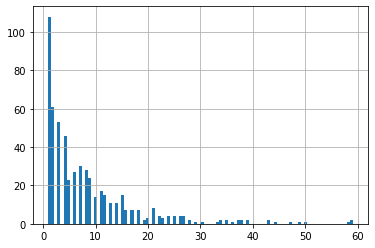

In [33]:
#distribution of jumpman delivery people
df.jumpman_id.value_counts().hist(bins=100)

In [34]:
df.jumpman_id.value_counts().sort_values(ascending=False)

104533    59
99219     59
142394    58
30743     50
3296      49
          ..
177125     1
64628      1
94614      1
137979     1
159647     1
Name: jumpman_id, Length: 565, dtype: int64

In [35]:
top_3 = ['99219','104533','142394']
df[df.jumpman_id.isin(top_3)]

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,haversine_distance_km,avg_vehicle_rate_kms
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3,Munchables,0 days 00:25:09.107093,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.654910,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873,0.44,0.002127
21,1356218,128224,99219,bicycle,Osteria Morini,Italian,Garganelli,1,Pasta,Not Disclosed,40.721953,-73.997737,40.716720,-74.012300,2014-10-13 18:00:38.265026,2014-10-13 18:01:53.350477,2014-10-13 18:30:02.582698,2014-10-13 18:40:48.499622,1.36,0.002127
24,1488027,396432,99219,bicycle,Juice Press,Juice Bar,Rehab Shot,2,Other Beverages,Not Disclosed,40.725948,-74.001106,40.718659,-74.002854,2014-10-30 17:36:13.679620,2014-10-30 17:36:59.326686,2014-10-30 17:55:48.869001,2014-10-30 18:05:27.272486,0.82,0.002127
32,1467996,301380,142394,bicycle,ilili Restaurant,Middle Eastern,Hommus,1,Dips,0 days 00:05:16.988501,40.744188,-73.987531,40.734994,-73.987709,2014-10-27 13:18:37.395003,2014-10-27 13:30:46.385334,2014-10-27 13:46:07.104381,2014-10-27 13:57:18.114768,1.02,0.002127
53,1407558,41130,99219,bicycle,Village Yogurt,Not Disclosed,Not Disclosed,Not Disclosed,Not Disclosed,Not Disclosed,40.737888,-73.996460,40.722746,-73.998857,2014-10-20 11:34:27.673232,2014-10-20 11:35:39.406833,2014-10-20 11:45:29.157896,2014-10-20 11:55:03.887998,1.70,0.002127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453,1412950,374826,104533,bicycle,Waverly Diner,American,Linzer Tart,1,Desserts,Not Disclosed,40.733012,-74.000056,40.723061,-74.008280,2014-10-21 01:32:28.490579,2014-10-21 01:35:43.948815,2014-10-21 01:47:18.834652,2014-10-21 02:17:23.383088,1.31,0.002127
5473,1272439,354016,99219,bicycle,Waverly Diner,American,Cappuccino,1,Gourmet Coffee,0 days 00:04:08.730077,40.733012,-74.000056,40.723329,-73.991502,2014-10-01 10:54:28.015258,2014-10-01 11:08:57.885556,2014-10-01 11:15:17.553251,2014-10-01 11:24:58.870870,1.30,0.002127
5544,1489657,390459,104533,bicycle,Shake Shack,Burger,Bottled Water,1,Drinks,Not Disclosed,40.758457,-73.989140,40.750712,-74.002371,2014-10-30 20:21:01.542454,2014-10-30 20:29:06.666940,2014-10-30 21:05:59.314556,2014-10-30 21:18:13.905804,1.41,0.002127
5548,1341499,67370,104533,bicycle,Duane Reade,Drug Store,Not Disclosed,Not Disclosed,Not Disclosed,Not Disclosed,40.733407,-73.986724,40.727516,-73.984562,2014-10-11 20:28:59.236913,2014-10-11 20:43:07.273090,2014-10-11 20:51:59.962551,2014-10-11 20:58:41.812364,0.68,0.002127


In [36]:
df[df.how_long_it_took_to_order.isna()]

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,haversine_distance_km,avg_vehicle_rate_kms


In [37]:
df.groupby(by='pickup_place').count().sort_values(by='delivery_id', ascending=False)

,delivery_id,customer_id,jumpman_id,vehicle_type,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,haversine_distance_km,avg_vehicle_rate_kms
pickup_place,,,,,,,,,,,,,,,,,,,
Shake Shack,247,247,247,247,247,247,247,247,247,247,247,247,247,247,247,247,247,247,247
Momofuku Milk Bar,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156
The Meatball Shop,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147
sweetgreen,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125,125
Blue Ribbon Fried Chicken,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eastside Cellars,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Navy,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Natureworks,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [38]:
len(df['pickup_place'].unique())

835

In [39]:
df[df['pickup_place']=='Shake Shack']

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,haversine_distance_km,avg_vehicle_rate_kms
9,1417206,153816,157415,car,Shake Shack,Burger,Shackburger,1,Burgers,Not Disclosed,40.758457,-73.989140,40.743613,-73.977684,2014-10-21 21:18:37.909545,2014-10-21 21:20:14.434227,2014-10-21 21:47:03.624931,2014-10-21 21:59:26.081278,1.91,0.002448
22,1320596,368663,125504,bicycle,Shake Shack,Burger,Shack-cago Dog,1,Flat-Top Dogs,Not Disclosed,40.780826,-73.976483,40.801488,-73.969690,2014-10-08 20:53:52.039403,2014-10-08 20:59:18.079384,2014-10-08 21:14:42.577492,2014-10-08 21:23:52.213217,2.37,0.002127
48,1320822,149508,43955,bicycle,Shake Shack,Burger,Cheese Fries,1,Fries,Not Disclosed,40.715279,-74.014860,40.716168,-74.003693,2014-10-08 21:18:11.900324,2014-10-08 21:28:15.142224,2014-10-08 21:47:35.029385,2014-10-08 21:54:36.734336,0.95,0.002127
64,1414452,148033,128139,car,Shake Shack,Burger,Not Disclosed,Not Disclosed,Not Disclosed,Not Disclosed,40.682770,-73.976532,40.693256,-73.966173,2014-10-21 14:57:29.338613,2014-10-21 15:30:02.259968,2014-10-21 15:31:21.050095,2014-10-21 15:37:44.276996,1.46,0.002448
137,1299559,148327,118093,scooter,Shake Shack,Burger,Fries,1,Fries,Not Disclosed,40.692146,-73.988865,40.701972,-73.987036,2014-10-05 12:30:23.277890,2014-10-05 13:07:23.307290,2014-10-05 13:26:13.134353,2014-10-05 13:35:38.318512,1.10,0.002529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5856,1362784,196337,134189,car,Shake Shack,Burger,Fries,1,Fries,Not Disclosed,40.779126,-73.954905,40.776129,-73.952748,2014-10-14 19:44:01.149226,2014-10-14 19:53:45.141067,2014-10-14 20:14:04.967826,2014-10-14 20:20:48.416561,0.38,0.002448
5873,1393083,58675,140096,bicycle,Shake Shack,Burger,Fries,2,Fries,Not Disclosed,40.715279,-74.014860,40.707930,-74.006463,2014-10-18 21:22:08.439224,2014-10-18 22:00:41.705364,2014-10-18 22:19:00.988894,2014-10-18 22:27:25.991452,1.08,0.002127
5895,1300312,361651,44938,walker,Shake Shack,Burger,Shackburger,3,Burgers,Not Disclosed,40.758457,-73.989140,40.766912,-73.984086,2014-10-05 13:54:59.148422,2014-10-05 13:56:22.493833,2014-10-05 14:25:17.324140,2014-10-05 14:41:47.680372,1.03,0.002143
5962,1483811,180567,41408,car,Shake Shack,Burger,Shack -Cago Dog,1,Flat Top Dogs,Not Disclosed,40.715279,-74.014860,40.722574,-74.010246,2014-10-29 22:37:52.579546,2014-10-29 22:40:28.989659,2014-10-29 22:58:21.162858,2014-10-29 23:02:48.791177,0.90,0.002448


<a id='scratch'></a>
## Scratch

rate = df.iloc[0]['avg_vehicle_rate_kms']
distance = df.iloc[0]['haversine_distance_km']
time = distance/rate
time = time.astype('timedelta64[s]')
time

print(df.iloc[0]['when_the_Jumpman_arrived_at_dropoff'])
print(df.iloc[0]['when_the_Jumpman_arrived_at_dropoff'] - time)

df['time_pickup_to_dropoff'] = df['haversine_distance_km']/df['avg_vehicle_rate_kms']
df['time_pickup_to_dropoff'] = df['time_pickup_to_dropoff'].astype('timedelta64[s]')

for i in df[df['when_the_Jumpman_left_pickup'].isna()].index:
    #rate = df.iloc[i]['avg_vehicle_rate_kms']
    #distance = df.iloc[i]['haversine_distance_km']
    #time = (distance/rate).astype('timedelta64[s]')
    #df.iloc[i]['when_the_Jumpman_left_pickup'] = (df.iloc[i]['when_the_Jumpman_arrived_at_dropoff'] - (df.iloc[0]['haversine_distance_km']/df.iloc[i]['avg_vehicle_rate_kms']).astype('timedelta64[s]'))
    print(df.iloc[i]['when_the_Jumpman_arrived_at_dropoff'] - df.iloc[i])
    
    
    
    
null_pickup = df[df['when_the_Jumpman_left_pickup'].isnull()].index.to_list()

for i in null_pickup:
    df.loc[i]['when_the_Jumpman_left_pickup'] = df.loc[i]['when_the_Jumpman_arrived_at_dropoff'] - df.loc[i]['time_pickup_to_dropoff']

#df.iloc[0]['how_long_it_took_to_order'].minutes

time_cols = ['how_long_it_took_to_order']
for i in time_cols:
    df[i] = pd.to_datetime(df[i])
    
    
def minutes(data_input):
    return data_input.minute*60.0 + data_input.second

minute = df.how_long_it_took_to_order.apply(minutes)
df['min_to_order'] = round(minute/60,2)

df['how_long_it_took_to_order'] = pd.to_datetime(df.how_long_it_took_to_order, format = '%H:%M:%S.%f')

df['min_to_order'].hist(bins=50)
df['min_to_order'].describe()
sns.boxplot(y="min_to_order", data=df, orient='h')
sns.violinplot(x="vehicle_type", y="min_to_order", data=df, split=False, inner="quart", linewidth=1.3)